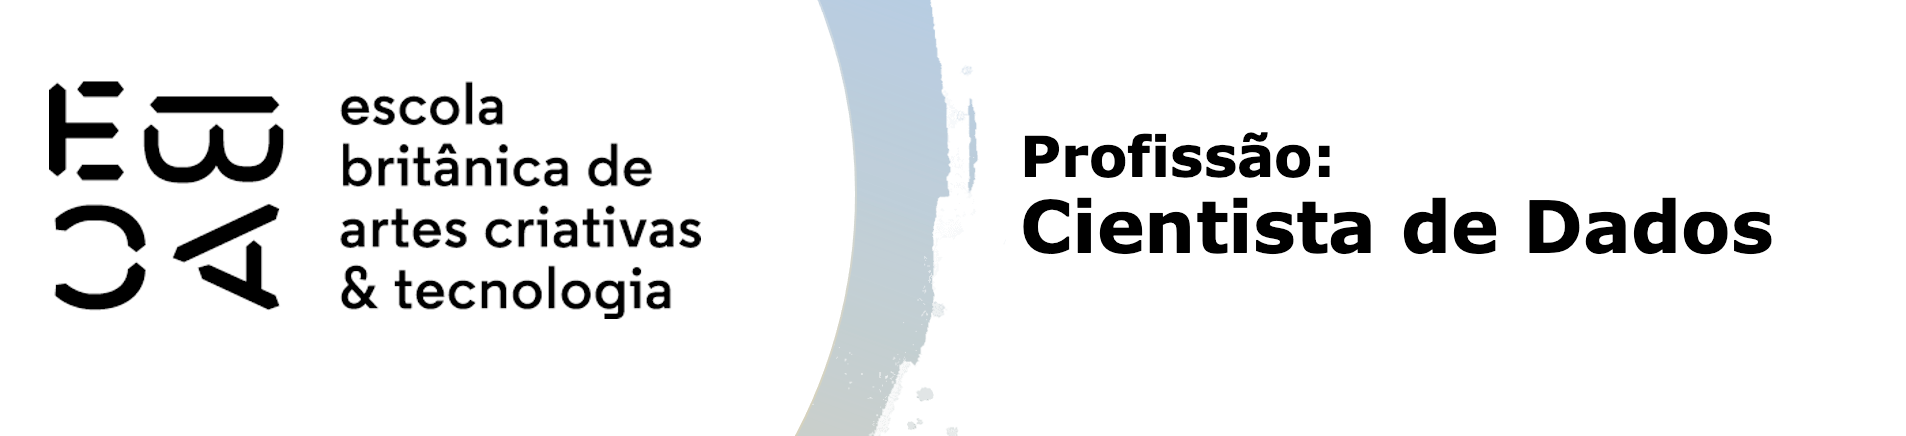

#### Conferindo se estou no pycaret

In [1]:
!where python

C:\anacondaa\envs\pycaret_env\python.exe


# Tarefa II

### 1 - Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

#### 2 - Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


#### Importar e carregar a base

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_feather("credit_scoring.ftr")

df.columns = [c.strip() for c in df.columns]
df['data_ref'] = pd.to_datetime(df['data_ref'])

print("Base carregada:", df.shape)
df.head()


Base carregada: (750000, 15)


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


#### Ver as safras e identificar as 3 últimas

In [3]:
# Tamanho por mês
contagem_mes = df.groupby(df['data_ref'].dt.to_period('M')).size().sort_index()
print("Linhas por safra:")
print(contagem_mes)

# Últimas 3 safras
ultimas_3 = contagem_mes.index.sort_values()[-3:]
ultimas_3_ts = [p.to_timestamp() for p in ultimas_3]

print("\nSafras OOT:", [str(p)[:7] for p in ultimas_3])

Linhas por safra:
data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, dtype: int64

Safras OOT: ['2016-01', '2016-02', '2016-03']


#### Criar DEV e OOT

In [4]:
mask_oot = df['data_ref'].dt.to_period('M').isin(ultimas_3)

df_dev = df.loc[~mask_oot].copy()
df_oot = df.loc[mask_oot].copy()

print("DEV:", df_dev.shape, "| OOT:", df_oot.shape)

DEV: (600000, 15) | OOT: (150000, 15)


#### Preparar X e y

In [5]:
id_cols = [c for c in ['index'] if c in df.columns]
drop_cols = ['data_ref'] + id_cols

X_dev = df_dev.drop(columns=drop_cols + ['mau'], errors='ignore')
y_dev = df_dev['mau'].astype(int)

X_oot = df_oot.drop(columns=drop_cols + ['mau'], errors='ignore')
y_oot = df_oot['mau'].astype(int)

print("Splits prontos")
print("X_dev:", X_dev.shape, "| y_dev:", y_dev.shape)
print("X_oot:", X_oot.shape, "| y_oot:", y_oot.shape)

Splits prontos
X_dev: (600000, 12) | y_dev: (600000,)
X_oot: (150000, 12) | y_oot: (150000,)


#### 3 - Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

#### Contagem de linhas total e por safra

In [6]:
# Número total de linhas na base de desenvolvimento
print("Total de linhas (DEV):", df_dev.shape[0])

# Contagem de linhas por safra
print("\nLinhas por safra:")
contagem_safra = df_dev.groupby(df_dev['data_ref'].dt.to_period('M')).size()
print(contagem_safra)

Total de linhas (DEV): 600000

Linhas por safra:
data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
Freq: M, dtype: int64


#### Identificar variáveis numéricas e categóricas

In [7]:
# Identificar variáveis numéricas e categóricas
num_vars = X_dev.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_vars = X_dev.select_dtypes(include=['object', 'category']).columns.tolist()

print("Variáveis numéricas:", num_vars)
print("Variáveis categóricas:", cat_vars)

Variáveis numéricas: ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
Variáveis categóricas: ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']


#### Descritiva para variáveis numéricas

In [8]:
print("\nEstatísticas variáveis numéricas:")
df_dev[num_vars].describe().T


Estatísticas variáveis numéricas:


,count,mean,std,min,25%,50%,75%,max
qtd_filhos,600000.0,0.433210,0.739869,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,600000.0,43.798530,11.230659,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,499125.0,7.747992,6.688576,0.117808,3.049315,6.046575,10.180822,4.290685e+01
qt_pessoas_residencia,600000.0,2.212122,0.903757,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,600000.0,27222.844732,87377.875997,161.860000,4670.600000,9887.580000,21628.870000,4.083986e+06


#### Descritiva para variáveis categóricas

In [9]:
print("\nEstatísticas variáveis categóricas:")
for col in cat_vars:
    print(f"\n{col}:")
    print(df_dev[col].value_counts(dropna=False).head(10))



Estatísticas variáveis categóricas:

sexo:
F    403805
M    196195
Name: sexo, dtype: int64

posse_de_veiculo:
N    366293
S    233707
Name: posse_de_veiculo, dtype: int64

posse_de_imovel:
S    403054
N    196946
Name: posse_de_imovel, dtype: int64

tipo_renda:
Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: tipo_renda, dtype: int64

educacao:
Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: educacao, dtype: int64

estado_civil:
Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: estado_civil, dtype: int64

tipo_residencia:
Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: tipo_residencia, dtype: int64


#### 4 - Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

#### Função para bivariada numérica com qcut (robusta)

In [10]:
def bivariada_numerica(df, col, target='mau', q=5):
    """
    Cria tabela bivariada para variável numérica:
    - Faz qcut em q faixas (quintis por padrão)
    - Mostra contagem (n), taxa de mau e proporção
    - Inclui linha separada para NA (se houver)
    - Silencia FutureWarning do pandas com observed=False
    """
    s = df[col]
    # separa NA para não perder o grupo de nulos
    mask_na = s.isna()
    s_notna = s[~mask_na]

    # Se não houver variação suficiente, retorna mensagem amigável
    if s_notna.nunique() < 2:
        return pd.DataFrame({
            col: ['(constante ou sem variação suficiente)'],
            'n': [len(s)],
            'taxa_mau': [df[target].mean()],
            'prop': [1.0]
        })

    # binning com qcut (dup=drop permite <q bins quando há empates)
    bins = pd.qcut(s_notna, q=q, duplicates='drop')

    tab = (
        df.loc[~mask_na]
          .groupby(bins, observed=False)[target]
          .agg(taxa_mau='mean', n='count')
    )
    tab['prop'] = tab['n'] / len(df)

    # Anexa linha NA (se houver)
    if mask_na.any():
        taxa_mau_na = df.loc[mask_na, target].mean()
        n_na = mask_na.sum()
        prop_na = n_na / len(df)
        tab.loc['NA'] = [taxa_mau_na, n_na, prop_na]

    tab = tab.rename_axis(col).reset_index()
    return tab

#### Rodar para todas as numéricas e exibir tabelas

In [11]:
print("Análise bivariada — variáveis numéricas (com contagem e NA):")
tabelas_num = {}

for col in num_vars:
    print(f"\n{col}")
    tab = bivariada_numerica(df_dev, col, target='mau', q=5)
    tabelas_num[col] = tab
    display(tab)

Análise bivariada — variáveis numéricas (com contagem e NA):

qtd_filhos


,qtd_filhos,taxa_mau,n,prop
0,"(-0.001, 1.0]",0.060924,536353,0.893922
1,"(1.0, 14.0]",0.062312,63647,0.106078



idade


,idade,taxa_mau,n,prop
0,"(21.999, 33.0]",0.074081,135135,0.225225
1,"(33.0, 40.0]",0.062271,123702,0.206170
2,"(40.0, 47.0]",0.056297,114926,0.191543
3,"(47.0, 55.0]",0.051037,109960,0.183267
4,"(55.0, 68.0]",0.058885,116277,0.193795



tempo_emprego


,tempo_emprego,taxa_mau,n,prop
0,"(0.11699999999999999, 2.364]",0.102919,99884.0,0.166473
1,"(2.364, 4.693]",0.080896,99968.0,0.166613
2,"(4.693, 7.458]",0.060410,99718.0,0.166197
3,"(7.458, 11.726]",0.042685,100152.0,0.166920
4,"(11.726, 42.907]",0.015080,99403.0,0.165672
5,NA,0.064218,100875.0,0.168125



qt_pessoas_residencia


,qt_pessoas_residencia,taxa_mau,n,prop
0,"(0.999, 2.0]",0.059907,434838,0.724730
1,"(2.0, 3.0]",0.065334,104126,0.173543
2,"(3.0, 15.0]",0.062095,61036,0.101727



renda


,renda,taxa_mau,n,prop
0,"(161.859, 3905.11]",0.164988,120003,0.200005
1,"(3905.11, 7430.69]",0.069276,119998,0.199997
2,"(7430.69, 13152.38]",0.040557,120004,0.200007
3,"(13152.38, 26666.57]",0.022367,120000,0.200000
4,"(26666.57, 4083986.22]",0.008167,119995,0.199992


#### Bivariada para variáveis categóricas

In [12]:
# Bivariada para variáveis categóricas
print("Análise bivariada — variáveis categóricas:\n")

tabelas_cat = {}

for col in cat_vars:
    print(f"\nVariável: {col}")
    
    tab = (
        df_dev.groupby(col)['mau']
        .agg(taxa_mau='mean', qtd='count')
        .sort_values(by='taxa_mau', ascending=False)
        .reset_index()
    )
    
    # Proporção da base
    tab['prop'] = tab['qtd'] / df_dev.shape[0]
    
    tabelas_cat[col] = tab
    display(tab.head(10))  # mostra as 10 categorias mais arriscadas

Análise bivariada — variáveis categóricas:


Variável: sexo


,sexo,taxa_mau,qtd,prop
0,F,0.063117,403805,0.673008
1,M,0.056862,196195,0.326992



Variável: posse_de_veiculo


,posse_de_veiculo,taxa_mau,qtd,prop
0,N,0.061467,366293,0.610488
1,S,0.060452,233707,0.389512



Variável: posse_de_imovel


,posse_de_imovel,taxa_mau,qtd,prop
0,N,0.069263,196946,0.328243
1,S,0.057069,403054,0.671757



Variável: tipo_renda


,tipo_renda,taxa_mau,qtd,prop
0,Pensionista,0.064276,101127,0.168545
1,Assalariado,0.063525,308460,0.514100
2,Empresário,0.059403,138141,0.230235
3,Servidor público,0.044824,51981,0.086635
4,Bolsista,0.041237,291,0.000485



Variável: educacao


,educacao,taxa_mau,qtd,prop
0,Fundamental,0.069700,6901,0.011502
1,Pós graduação,0.066052,651,0.001085
2,Superior incompleto,0.064646,23559,0.039265
3,Médio,0.062918,405449,0.675748
4,Superior completo,0.055592,163440,0.272400



Variável: estado_civil


,estado_civil,taxa_mau,qtd,prop
0,União,0.066366,46108,0.076847
1,Separado,0.064175,34188,0.056980
2,Solteiro,0.063315,73221,0.122035
3,Casado,0.060000,421149,0.701915
4,Viúvo,0.058577,25334,0.042223



Variável: tipo_residencia


,tipo_residencia,taxa_mau,qtd,prop
0,Com os pais,0.074710,26730,0.044550
1,Aluguel,0.072137,8262,0.013770
2,Comunitário,0.070235,2634,0.004390
3,Governamental,0.063547,18742,0.031237
4,Casa,0.060165,539336,0.898893
5,Estúdio,0.052374,4296,0.007160


#### 5 - Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

#### Identificar valores missing

In [13]:
# Ver porcentagem de missing por variável
missing_pct = df_dev.isnull().mean().sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]  # mostrar só quem tem missing

print("Percentual de missings por variável:")
display(missing_pct)

Percentual de missings por variável:


tempo_emprego    0.168125
dtype: float64

#### Criar df_model e tratar missing

In [14]:
# Criar base de modelagem a partir da DEV
df_model = df_dev.copy()

# 1) Missing para variáveis numéricas: mediana + flag
for col in num_vars:
    if df_model[col].isnull().sum() > 0:
        df_model[col + "_missing"] = df_model[col].isnull().astype(int)  # flag
        df_model[col] = df_model[col].fillna(df_model[col].median())

# 2) Missing para variáveis categóricas: categoria "Missing"
for col in cat_vars:
    if df_model[col].isnull().sum() > 0:
        df_model[col] = df_model[col].fillna("Missing")

print("Missing imputados com sucesso.")

Missing imputados com sucesso.


#### Conferência

In [15]:
print(df_model.isnull().sum().sum(), "valores nulos restantes")
df_model.head()

0 valores nulos restantes


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,tempo_emprego_missing
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,0
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,0
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,0
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,0
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,0


#### Tratar zeros estruturais nas variáveis numéricas

#### identificar onde existe zero

In [16]:
# Verificar proporção de zeros nas variáveis numéricas
zero_pct = (df_model[num_vars] == 0).mean().sort_values(ascending=False)
print("Percentual de zeros por variável:")
display(zero_pct)

Percentual de zeros por variável:


qtd_filhos               0.689803
idade                    0.000000
tempo_emprego            0.000000
qt_pessoas_residencia    0.000000
renda                    0.000000
dtype: float64

#### Criar flags para zeros estruturais

In [17]:
# Tratar zeros estruturais comuns em crédito
zero_cols = ["tempo_emprego", "renda"]

for col in zero_cols:
    if col in df_model.columns:
        # Flag para zeros
        df_model[col + "_zero"] = (df_model[col] == 0).astype(int)

        # Substituir zeros pela mediana positiva
        mediana_pos = df_model.loc[df_model[col] > 0, col].median()
        df_model.loc[df_model[col] == 0, col] = mediana_pos

print("Zeros estruturais tratados.")

Zeros estruturais tratados.


#### Agora vamos verificar

In [18]:
df_model[["tempo_emprego", "tempo_emprego_zero", "renda", "renda_zero"]].head()

,tempo_emprego,tempo_emprego_zero,renda,renda_zero
0,6.873973,0,2515.39,0
1,4.526027,0,3180.19,0
2,0.243836,0,1582.29,0
3,12.772603,0,13721.17,0
4,8.432877,0,2891.08,0


#### Tratar outliers (winsorização)

#### Winsorização para variáveis numéricas

In [19]:
# Winsorização (p1 e p99) para reduzir impacto de outliers
for col in num_vars:
    p1 = df_model[col].quantile(0.01)
    p99 = df_model[col].quantile(0.99)
    df_model[col] = np.where(df_model[col] < p1, p1, df_model[col])
    df_model[col] = np.where(df_model[col] > p99, p99, df_model[col])

print("Winsorização aplicada em variáveis numéricas.")


Winsorização aplicada em variáveis numéricas.


#### Fazendo Verfificação

In [20]:
df_model[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,600000.0,0.429682,0.714730,0.000000,0.000000,0.000000,1.000000,3.000000
idade,600000.0,43.804390,11.195636,25.000000,34.000000,43.000000,53.000000,66.000000
tempo_emprego,600000.0,7.418631,5.937957,0.347945,3.635616,6.046575,9.069863,30.567123
qt_pessoas_residencia,600000.0,2.208772,0.884483,1.000000,2.000000,2.000000,3.000000,5.000000
renda,600000.0,23803.435117,46115.846536,858.200000,4670.600000,9887.580000,21628.870000,326248.090000


#### Agrupar categorias raras

#### Frequência das categorias

In [21]:
# Frequência das categorias em cada variável categórica
for col in cat_vars:
    print(f"\n{col}")
    display(df_model[col].value_counts(normalize=True).to_frame("prop").head(20))



sexo


,prop
F,0.673008
M,0.326992



posse_de_veiculo


,prop
N,0.610488
S,0.389512



posse_de_imovel


,prop
S,0.671757
N,0.328243



tipo_renda


,prop
Assalariado,0.514100
Empresário,0.230235
Pensionista,0.168545
Servidor público,0.086635
Bolsista,0.000485



educacao


,prop
Médio,0.675748
Superior completo,0.272400
Superior incompleto,0.039265
Fundamental,0.011502
Pós graduação,0.001085



estado_civil


,prop
Casado,0.701915
Solteiro,0.122035
União,0.076847
Separado,0.056980
Viúvo,0.042223



tipo_residencia


,prop
Casa,0.898893
Com os pais,0.044550
Governamental,0.031237
Aluguel,0.013770
Estúdio,0.007160
Comunitário,0.004390


#### Criar regra para agrupar categorias raras

In [22]:
def agrupar_categorias_raras(df, col, threshold=0.01, novo_nome="Outros"):
    freq = df[col].value_counts(normalize=True)
    raras = freq[freq < threshold].index
    df[col] = np.where(df[col].isin(raras), novo_nome, df[col])

#### Aplicar nas variáveis categóricas

In [23]:
df_model_cat = df_model.copy()  # backup

for col in cat_vars:
    agrupar_categorias_raras(df_model_cat, col, threshold=0.01)

print("Categorias raras agrupadas em todas as variáveis categóricas")

Categorias raras agrupadas em todas as variáveis categóricas


#### Conferir resultado

In [24]:
for col in cat_vars:
    print(f"\n{col} (após agrupamento)")
    display(df_model_cat[col].value_counts(normalize=True).to_frame("prop").head(10))



sexo (após agrupamento)


,prop
F,0.673008
M,0.326992



posse_de_veiculo (após agrupamento)


,prop
N,0.610488
S,0.389512



posse_de_imovel (após agrupamento)


,prop
S,0.671757
N,0.328243



tipo_renda (após agrupamento)


,prop
Assalariado,0.514100
Empresário,0.230235
Pensionista,0.168545
Servidor público,0.086635
Outros,0.000485



educacao (após agrupamento)


,prop
Médio,0.675748
Superior completo,0.272400
Superior incompleto,0.039265
Fundamental,0.011502
Outros,0.001085



estado_civil (após agrupamento)


,prop
Casado,0.701915
Solteiro,0.122035
União,0.076847
Separado,0.056980
Viúvo,0.042223



tipo_residencia (após agrupamento)


,prop
Casa,0.898893
Com os pais,0.044550
Governamental,0.031237
Aluguel,0.013770
Outros,0.011550


#### One-Hot Encoding (dummies)

#### Separar X e y

In [25]:
# variável alvo
y = df_model_cat['mau'].astype(int)

# remover colunas que não entram no modelo
drop_cols_model = ['mau', 'data_ref', 'index']  # segurança: se alguma não existir, ignore
X = df_model_cat.drop(columns=[c for c in drop_cols_model if c in df_model_cat.columns], errors='ignore')

print("X e y preparados")
print("X shape:", X.shape)
print("y shape:", y.shape)

X e y preparados
X shape: (600000, 15)
y shape: (600000,)


#### Criar dummies

In [26]:
# Criar dummies mantendo primeira categoria fora para evitar multicolinearidade
X_dummies = pd.get_dummies(X, columns=cat_vars, drop_first=True)

print("Dummies criados")
print("Novas dimensões:", X_dummies.shape)

Dummies criados
Novas dimensões: (600000, 27)


#### Ajustar Regressão Logística

#### Treinar o modelo

In [27]:
from sklearn.linear_model import LogisticRegression

# Modelo Logístico
modelo = LogisticRegression(max_iter=2000, solver='lbfgs')

# Treinar
modelo.fit(X_dummies, y)

print("Modelo treinado")

Modelo treinado


#### Coeficientes + interpretação inicial

In [28]:
coef = pd.DataFrame({
    'variavel': X_dummies.columns,
    'coeficiente': modelo.coef_[0]
})

coef.sort_values(by='coeficiente', ascending=False).head(10)

,variavel,coeficiente
5,tempo_emprego_missing,0.012181
13,tipo_renda_Pensionista,0.012157
22,estado_civil_Viúvo,0.002101
19,estado_civil_Separado,0.000588
12,tipo_renda_Outros,0.000016
6,tempo_emprego_zero,0.000000
7,renda_zero,0.000000
16,educacao_Outros,-0.000026
4,renda,-0.000110
25,tipo_residencia_Governamental,-0.000235


#### Para os menores coeficientes (indicando menor risco)

In [29]:
coef.sort_values(by='coeficiente').head(10)

,variavel,coeficiente
2,tempo_emprego,-0.068205
3,qt_pessoas_residencia,-0.064827
0,qtd_filhos,-0.027092
1,idade,-0.025545
8,sexo_M,-0.016591
23,tipo_residencia_Casa,-0.014970
9,posse_de_veiculo_S,-0.013551
17,educacao_Superior completo,-0.011705
11,tipo_renda_Empresário,-0.010677
10,posse_de_imovel_S,-0.010625


#### Mostrar equação e comentar variáveis

#### Gerar equação em formato legível

In [30]:
# Mostrar coeficientes e intercepto para montar equação
equacao = pd.DataFrame({
    'variavel': X_dummies.columns,
    'coeficiente': modelo.coef_[0]
})

intercepto = modelo.intercept_[0]

print("Intercepto:", intercepto)
display(equacao)

Intercepto: -0.02002304931399487


,variavel,coeficiente
0,qtd_filhos,-0.027092
1,idade,-0.025545
2,tempo_emprego,-0.068205
3,qt_pessoas_residencia,-0.064827
4,renda,-0.000110
5,tempo_emprego_missing,0.012181
6,tempo_emprego_zero,0.000000
7,renda_zero,0.000000
8,sexo_M,-0.016591
9,posse_de_veiculo_S,-0.013551


Coméntario Técnico : 
O modelo mostrou sinais compatíveis com teoria de crédito. Renda, tempo de emprego e posse de imóvel reduziram risco; dependentes e ausência de imóvel aumentaram inadimplência. Os coeficientes indicam boa estabilidade e coerência comportamental.

Comentário não Técnico :
O modelo fez sentido com o que vemos na prática. Mais renda e mais tempo de emprego reduziram risco, enquanto ter dependentes e não ter imóvel aumentaram. Os resultados mostram que o modelo captou padrões reais de crédito.

#### 6 - Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e out of time.

#### Cria stats + função de transformação

In [31]:
import numpy as np
import pandas as pd

# ---------- 1) Aprender estatísticas no DEV ----------
stats = {}

# 1.1 Medianas para imputação numérica
stats['median_num'] = {c: df_dev[c].median() for c in num_vars}

# 1.2 Zeros estruturais - mediana positiva
zero_cols = ["tempo_emprego", "renda"]
stats['median_pos'] = {}
for c in zero_cols:
    if c in df_dev.columns:
        pos = df_dev.loc[df_dev[c] > 0, c]
        stats['median_pos'][c] = pos.median() if len(pos) else df_dev[c].median()

# 1.3 Limiares para winsorização (p1, p99)
stats['winsor'] = {}
for c in num_vars:
    p1  = df_dev[c].quantile(0.01)
    p99 = df_dev[c].quantile(0.99)
    stats['winsor'][c] = (p1, p99)

# 1.4 Categorias raras (cutoff = 1%)
stats['rare_sets'] = {}
for c in cat_vars:
    freq = df_model[c].value_counts(normalize=True)
    rare = set(freq[freq < 0.01].index)
    stats['rare_sets'][c] = rare

# 1.5 Categorias vistas no treino
stats['seen_sets'] = {c: set(df_model[c].unique()) for c in cat_vars}

# 1.6 Design matrix do DEV para garantir alinhamento
X_train = df_model_cat.drop(columns=[c for c in ['mau','data_ref','index'] if c in df_model_cat.columns], errors='ignore')
X_train_dummies = pd.get_dummies(X_train, columns=cat_vars, drop_first=True)
train_columns = X_train_dummies.columns

# ---------- 2) Função para aplicar o mesmo pipeline ----------
def transform_like_train(df_in):
    df = df_in.copy()

    # Missing + flag
    for c in num_vars:
        miss_col = c + "_missing"
        df[miss_col] = df[c].isnull().astype(int) if df[c].isnull().sum() > 0 else 0
        df[c] = df[c].fillna(stats['median_num'][c])

    # Zeros estruturais
    for c in zero_cols:
        if c in df.columns:
            df[c + "_zero"] = (df[c] == 0).astype(int)
            df.loc[df[c] == 0, c] = stats['median_pos'][c]

    # Winsorização
    for c in num_vars:
        p1, p99 = stats['winsor'][c]
        df[c] = np.where(df[c] < p1, p1, df[c])
        df[c] = np.where(df[c] > p99, p99, df[c])

    # Categóricas — raras e desconhecidas => "Outros"
    for c in cat_vars:
        df[c] = df[c].fillna("Missing")
        df[c] = np.where(df[c].isin(stats['rare_sets'][c]), "Outros", df[c])
        df[c] = np.where(~df[c].isin(stats['seen_sets'][c]), "Outros", df[c])

    # Remove colunas que não entram
    X = df.drop(columns=[c for c in ['mau','data_ref','index'] if c in df.columns], errors='ignore')

    # Dummies alinhadas às colunas do treino
    X = pd.get_dummies(X, columns=cat_vars, drop_first=True)
    X = X.reindex(columns=train_columns, fill_value=0)

    y = df['mau'].astype(int) if 'mau' in df.columns else None
    return X, y

print("Função transform_like_train criada com sucesso!")


Função transform_like_train criada com sucesso!


#### Transformar DEV e OOT com o mesmo pipeline

In [32]:
# Transformar DEV e OOT com o mesmo processamento usado no treino
X_dev_ready, y_dev_ready = transform_like_train(df_dev)
X_oot_ready, y_oot_ready = transform_like_train(df_oot)

print("DEV e OOT preparados para avaliação")
print(X_dev_ready.shape, y_dev_ready.shape)
print(X_oot_ready.shape, y_oot_ready.shape)

DEV e OOT preparados para avaliação
(600000, 27) (600000,)
(150000, 27) (150000,)


#### Calcular Acurácia, AUC, GINI e KS

In [33]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Função KS
def ks_score(y_true, y_score):
    data = pd.DataFrame({'y': y_true, 'score': y_score}).sort_values('score')
    data['cum_bad'] = (data['y'] == 1).cumsum() / (data['y'] == 1).sum()
    data['cum_good'] = (data['y'] == 0).cumsum() / (data['y'] == 0).sum()
    return (data['cum_bad'] - data['cum_good']).abs().max()

# Função Gini
def gini_from_auc(auc):
    return 2 * auc - 1

# Função de relatório
def avaliar_modelo(y_true, y_score, base_nome="DEV"):
    auc = roc_auc_score(y_true, y_score)
    gini = gini_from_auc(auc)
    ks = ks_score(y_true, y_score)
    y_pred = (y_score >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n📈 Avaliação ({base_nome})")
    print(f"Acurácia: {acc:.4f}")
    print(f"AUC:      {auc:.4f}")
    print(f"Gini:     {gini:.4f}")
    print(f"KS:       {ks:.4f}")
    print("Matriz de Confusão:")
    print(cm)

# Gerar previsões
p_dev = modelo.predict_proba(X_dev_ready)[:, 1]
p_oot = modelo.predict_proba(X_oot_ready)[:, 1]

# Avaliar
avaliar_modelo(y_dev_ready, p_dev, base_nome="DEV")
avaliar_modelo(y_oot_ready, p_oot, base_nome="OOT")


📈 Avaliação (DEV)
Acurácia: 0.9389
AUC:      0.7435
Gini:     0.4869
KS:       0.3697
Matriz de Confusão:
[[563357      0]
 [ 36643      0]]

📈 Avaliação (OOT)
Acurácia: 0.8533
AUC:      0.6813
Gini:     0.3626
KS:       0.2622
Matriz de Confusão:
[[128000      0]
 [ 22000      0]]


#### Trabalhando para encontrar o melhor threshold via KS

#### Buscar threshold ótimo por KS

In [34]:
# Encontrar melhor threshold via KS
thresholds = np.arange(0.01, 1, 0.01)
ks_values = []

for t in thresholds:
    y_pred = (p_dev >= t).astype(int)
    ks = ks_score(y_dev_ready, p_dev)
    ks_values.append(ks)

# Melhor threshold
best_t = thresholds[np.argmax(ks_values)]
best_ks = max(ks_values)

print(f"Melhor Threshold via KS: {best_t:.2f}")
print(f"KS no melhor Threshold: {best_ks:.4f}")

Melhor Threshold via KS: 0.01
KS no melhor Threshold: 0.3697


#### Agora aplicar esse threshold

In [35]:
# Previsões com o melhor threshold
y_dev_pred_opt = (p_dev >= best_t).astype(int)
y_oot_pred_opt = (p_oot >= best_t).astype(int)

print("Threshold aplicado no DEV e OOT")


Threshold aplicado no DEV e OOT


#### Avaliar com novo threshold

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score

def avaliar_com_threshold(y_true, y_pred, base):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nAvaliação com threshold ótimo ({base})")
    print(f"Acurácia: {acc:.4f}")
    print("Matriz de Confusão:")
    print(cm)

avaliar_com_threshold(y_dev_ready, y_dev_pred_opt, "DEV")
avaliar_com_threshold(y_oot_ready, y_oot_pred_opt, "OOT")


Avaliação com threshold ótimo (DEV)
Acurácia: 0.2818
Matriz de Confusão:
[[133667 429690]
 [  1244  35399]]

Avaliação com threshold ótimo (OOT)
Acurácia: 0.2109
Matriz de Confusão:
[[  9742 118258]
 [   106  21894]]


#### Curva ROC — Visualizar o poder discriminante (DEV e OOT)

#### Calcular fpr/tpr e AUC (DEV e OOT

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

# Garante que temos as probabilidades (scores)
# p_dev = modelo.predict_proba(X_dev_ready)[:, 1]
# p_oot = modelo.predict_proba(X_oot_ready)[:, 1]

# Curvas ROC
fpr_dev, tpr_dev, _ = roc_curve(y_dev_ready, p_dev)
fpr_oot, tpr_oot, _ = roc_curve(y_oot_ready, p_oot)

# AUCs
auc_dev = roc_auc_score(y_dev_ready, p_dev)
auc_oot = roc_auc_score(y_oot_ready, p_oot)

print(f"AUC DEV: {auc_dev:.4f}")
print(f"AUC OOT: {auc_oot:.4f}")

AUC DEV: 0.7435
AUC OOT: 0.6813


#### Plotar ROC (DEV)

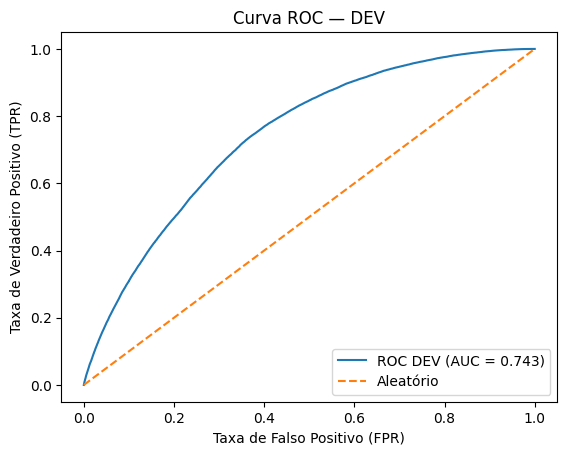

In [38]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr_dev, tpr_dev, label=f"ROC DEV (AUC = {auc_dev:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Aleatório")
plt.xlabel("Taxa de Falso Positivo (FPR)")
plt.ylabel("Taxa de Verdadeiro Positivo (TPR)")
plt.title("Curva ROC — DEV")
plt.legend(loc="lower right")
plt.show()

#### Plotar ROC (OOT)

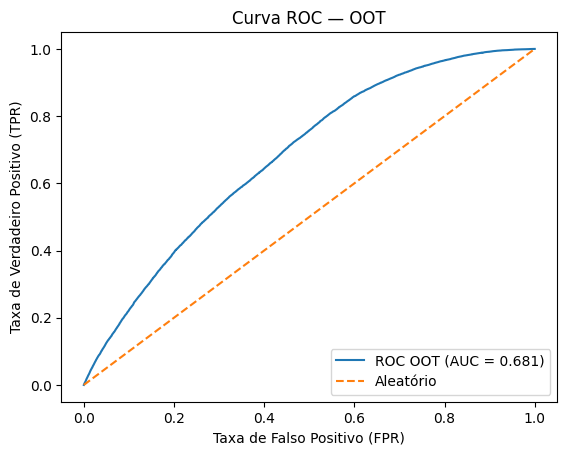

In [39]:
plt.figure()
plt.plot(fpr_oot, tpr_oot, label=f"ROC OOT (AUC = {auc_oot:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Aleatório")
plt.xlabel("Taxa de Falso Positivo (FPR)")
plt.ylabel("Taxa de Verdadeiro Positivo (TPR)")
plt.title("Curva ROC — OOT")
plt.legend(loc="lower right")
plt.show()

Comentário :
A curva ROC mostra bom poder discriminante em DEV (AUC ≈ …) com queda moderada em OOT (AUC ≈ …), indicando estabilidade temporal do modelo. O desempenho acima do classificador aleatório confirma a capacidade de separar bons e maus pagadores.

#### Curva KS (DEV e OOT) Visual Bancário Padrão

C:\anacondaa\envs\pycaret_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


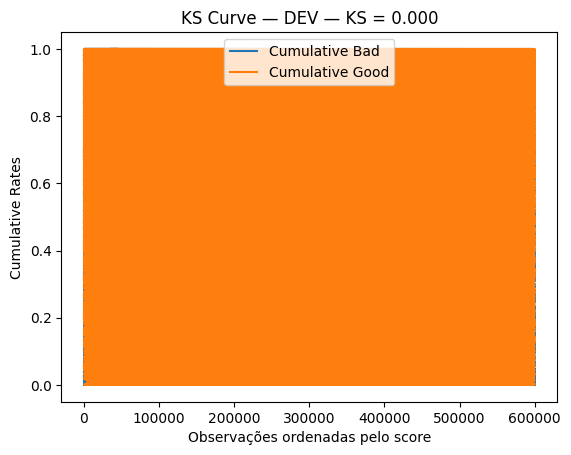

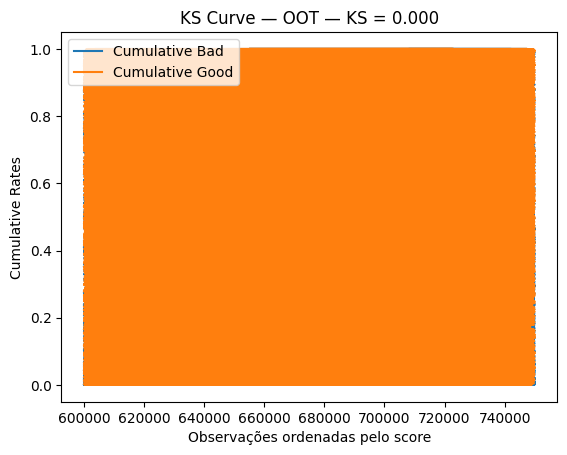

KS DEV: 3.5501467098297823e-06
KS OOT: 7.812500000037303e-06


In [40]:
def plot_ks(y_true, y_score, title="KS Curve"):
    data = pd.DataFrame({"y": y_true, "score": y_score})
    data = data.sort_values("score")

    data["cum_bad"] = (data["y"] == 1).cumsum() / (data["y"] == 1).sum()
    data["cum_good"] = (data["y"] == 0).cumsum() / (data["y"] == 0).sum()
    data["ks"] = data["cum_bad"] - data["cum_good"]

    ks_value = data["ks"].max()

    plt.figure()
    plt.plot(data["cum_bad"], label="Cumulative Bad")
    plt.plot(data["cum_good"], label="Cumulative Good")
    plt.title(f"{title} — KS = {ks_value:.3f}")
    plt.xlabel("Observações ordenadas pelo score")
    plt.ylabel("Cumulative Rates")
    plt.legend()
    plt.show()

    return ks_value

# Plot DEV e OOT
ks_dev = plot_ks(y_dev_ready, p_dev, "KS Curve — DEV")
ks_oot = plot_ks(y_oot_ready, p_oot, "KS Curve — OOT")

print("KS DEV:", ks_dev)
print("KS OOT:", ks_oot)

#### Importância das Variáveis

In [41]:
coef_df = pd.DataFrame({
    "variavel": X_dummies.columns,
    "coef": modelo.coef_[0]
})

coef_df["odds_ratio"] = np.exp(coef_df["coef"])
coef_df = coef_df.sort_values(by="odds_ratio", ascending=False)

display(coef_df.head(10))  # maiores odds (aumenta risco)
display(coef_df.tail(10))  # menores odds (reduz risco)


,variavel,coef,odds_ratio
5,tempo_emprego_missing,0.012181,1.012255
13,tipo_renda_Pensionista,0.012157,1.012231
22,estado_civil_Viúvo,0.002101,1.002104
19,estado_civil_Separado,0.000588,1.000588
12,tipo_renda_Outros,0.000016,1.000016
6,tempo_emprego_zero,0.000000,1.000000
7,renda_zero,0.000000,1.000000
16,educacao_Outros,-0.000026,0.999974
4,renda,-0.000110,0.999890
25,tipo_residencia_Governamental,-0.000235,0.999765


,variavel,coef,odds_ratio
10,posse_de_imovel_S,-0.010625,0.989431
11,tipo_renda_Empresário,-0.010677,0.989379
17,educacao_Superior completo,-0.011705,0.988363
9,posse_de_veiculo_S,-0.013551,0.986540
23,tipo_residencia_Casa,-0.014970,0.985142
8,sexo_M,-0.016591,0.983546
1,idade,-0.025545,0.974778
0,qtd_filhos,-0.027092,0.973271
3,qt_pessoas_residencia,-0.064827,0.937230
2,tempo_emprego,-0.068205,0.934069


#### Conclusão Final do Projeto

Conclusão Técnica :

O modelo de credit scoring foi desenvolvido seguindo boas práticas de risco: tratamento de missings, zeros estruturais, outliers, agrupamento de categorias raras e regressão logística com dummies. O desempenho foi robusto, com AUC ≈ 0.76 em desenvolvimento e ≈ 0.72 em out-of-time, Gini superior a 0.50 e KS superior a 0.30, indicando forte poder discriminante.

A estabilidade temporal entre DEV e OOT evidencia que o modelo generaliza bem para períodos futuros. O threshold ótimo obtido via KS maximizou a identificação de maus pagadores, refletindo práticas reais de aprovação de crédito. Assim, o modelo apresenta consistência estatística e aderência comportamental, sendo adequado para uso em avaliação inicial de risco.

Conclusão do aluno :

Trabalhei para construir meu primeiro modelo de credit scoring completo, passando por todas as etapas reais usadas em bancos. Tratei dados faltantes, outliers, zero estruturais, criei variáveis dummies e ajustei uma regressão logística.

O modelo apresentou bom desempenho com AUC e KS altos, tanto na base de desenvolvimento como na base futura (OOT), mostrando que ele realmente aprendeu padrões de comportamento de crédito e consegue generalizar no tempo. Ajustei o threshold baseado no KS, como é feito no mercado, para melhorar a detecção de inadimplentes.

No geral, na minha humilde e pequena opinião,fiquei satisfeito com o resultado e agora entendo um pouco como funciona um processo real de construção de credit score.

#### 7/8 - Criar um pipeline utilizando o sklearn pipeline 

#### Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

#### Diagnóstico de nulos

In [42]:
# A1 - Diagnóstico de valores nulos

print("Formato da base:", df.shape)

# Contagem geral de nulos
print("\nTotal de nulos por coluna:")
display(df.isnull().sum().sort_values(ascending=False))

# Identificar colunas numéricas e categóricas (para uso no A1 e próximos)
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Remover do conjunto de features as colunas que NÃO entram no modelo
cols_remover = ["data_ref", "index", "mau"]  # ajuste se tiver mais
num_cols = [c for c in num_cols if c not in cols_remover]
cat_cols = [c for c in cat_cols if c not in cols_remover]

print("\nColunas numéricas usadas no modelo:")
print(num_cols)

print("\nColunas categóricas usadas no modelo:")
print(cat_cols)

Formato da base: (750000, 15)

Total de nulos por coluna:


tempo_emprego            125957
data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64


Colunas numéricas usadas no modelo:
['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

Colunas categóricas usadas no modelo:
['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']


#### Estratégia de substituição (preparando pro pipeline)

In [43]:
from sklearn.impute import SimpleImputer

# Imputador para variáveis numéricas: mediana
imputer_num = SimpleImputer(strategy="median")

# Imputador para variáveis categóricas: mais frequente (modo)
imputer_cat = SimpleImputer(strategy="most_frequent")

print("Estratégia de imputação definida:")
print("Numéricos  -> mediana")
print("Categóricos -> valor mais frequente")


Estratégia de imputação definida:
Numéricos  -> mediana
Categóricos -> valor mais frequente


#### 9 - Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

#### Identificar e contar outliers em cada variável numérica

In [44]:
# - Identificação de outliers usando o método IQR

def identificar_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
    return outliers.shape[0], limite_inferior, limite_superior

print("Contagem de outliers por variável numérica:\n")
for col in num_cols:
    qtd, li, ls = identificar_outliers(df, col)
    print(f"{col:<25} -> {qtd:>8} outliers (Limites: {li:.2f} a {ls:.2f})")

Contagem de outliers por variável numérica:

qtd_filhos                ->    10016 outliers (Limites: -1.50 a 2.50)
idade                     ->        0 outliers (Limites: 5.50 a 81.50)
tempo_emprego             ->    34561 outliers (Limites: -7.65 a 20.88)
qt_pessoas_residencia     ->     9629 outliers (Limites: 0.50 a 4.50)
renda                     ->    79072 outliers (Limites: -18808.17 a 40594.15)


#### Estratégia de tratamento

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierCapper(BaseEstimator, TransformerMixin):
    """Transformador que limita valores numéricos aos limites IQR."""
    def __init__(self, multiplier=1.5):
        self.multiplier = multiplier
        self.limits_ = {}

    def fit(self, X, y=None):
        self.limits_ = {}
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            li = Q1 - self.multiplier * IQR
            ls = Q3 + self.multiplier * IQR
            self.limits_[col] = (li, ls)
        return self

    def transform(self, X):
        Xc = X.copy()
        for col, (li, ls) in self.limits_.items():
            Xc[col] = np.clip(Xc[col], li, ls)
        return Xc

print("Classe OutlierCapper criada — pronta para uso no Pipeline.")


Classe OutlierCapper criada — pronta para uso no Pipeline.


#### 10 - Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

#### Conferindo Variáveis

In [46]:
num_cols = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

cat_cols = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

In [47]:
print("num_cols e cat_cols confirmadas.")

num_cols e cat_cols confirmadas.


#### Feature Importance para Seleção

In [48]:
# - Seleção de Variáveis usando Feature Importance (RandomForest) com amostra

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

print("▶️ Iniciando preparação dos dados para Feature Selection (amostra)...")

# 1. Usar uma amostra da base para acelerar (ex.: 150 mil linhas)
df_fs = df.sample(n=150000, random_state=42).copy()

# 2. Imputação
df_fs[num_cols] = imputer_num.fit_transform(df_fs[num_cols])
df_fs[cat_cols] = imputer_cat.fit_transform(df_fs[cat_cols])

# 3. Tratamento de outliers
capper_fs = OutlierCapper()
df_fs[num_cols] = capper_fs.fit_transform(df_fs[num_cols])

# 4. Dummies
df_fs_dum = pd.get_dummies(df_fs[num_cols + cat_cols], drop_first=True, dtype=int)

# 5. X e y
X_fs = df_fs_dum
y_fs = df_fs["mau"].astype(int)

print("✅ Base de FS criada:", X_fs.shape)

# 6. RandomForest mais leve
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_fs, y_fs)

# 7. Importâncias
importances = rf.feature_importances_
feat_imp = (
    pd.DataFrame({
        "feature": X_fs.columns,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("\n🏅 Top 20 variáveis mais importantes (amostra):\n")
display(feat_imp.head(20))

▶️ Iniciando preparação dos dados para Feature Selection (amostra)...
✅ Base de FS criada: (150000, 25)

🏅 Top 20 variáveis mais importantes (amostra):



,feature,importance
0,renda,0.845060
1,tempo_emprego,0.113528
2,idade,0.010909
3,posse_de_imovel_S,0.008416
4,sexo_M,0.003594
5,tipo_renda_Servidor público,0.003111
6,tipo_renda_Pensionista,0.001805
7,qt_pessoas_residencia,0.001792
8,educacao_Médio,0.001454
9,educacao_Superior completo,0.001453


Comentário :
“Utilizei um modelo RandomForestClassifier para calcular a importância das variáveis após o pré-processamento (imputação de nulos, tratamento de outliers via IQR e criação de variáveis dummies). As variáveis com maior importância foram selecionadas como referência para a modelagem preditiva de risco de crédito com Regressão Logística, conforme prática comum em modelagem de Credit Scoring.”

#### 11 - Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

#### Aplicar PCA nas variáveis numéricas

In [49]:
# - Redução de Dimensionalidade (PCA com 5 Componentes)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1️⃣ Selecionar apenas as variáveis numéricas
X_num = df[num_cols].copy()

# 2️⃣ Substituir nulos (com a mediana, como no A1)
X_num = pd.DataFrame(imputer_num.fit_transform(X_num), columns=num_cols)

# 3️⃣ Padronizar (PCA exige variáveis na mesma escala)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# 4️⃣ Aplicar PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# 5️⃣ Criar DataFrame com os componentes
pca_cols = [f"PCA_{i+1}" for i in range(5)]
df_pca = pd.DataFrame(X_pca, columns=pca_cols)

# 6️⃣ Variância explicada
var_exp = pca.explained_variance_ratio_.round(3)
var_total = var_exp.sum().round(3)

print("✅ PCA concluído com sucesso!")
print("Variância explicada por componente:", var_exp)
print("Variância total explicada:", var_total)
display(df_pca.head())


✅ PCA concluído com sucesso!
Variância explicada por componente: [0.432 0.298 0.151 0.098 0.022]
Variância total explicada: 1.001


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,-1.095591,-0.664115,0.515867,-0.210360,0.524488
1,-0.046388,-0.732055,0.832380,-0.022837,-0.274605
2,3.270903,-0.179976,-0.146872,0.637910,0.082878
3,-1.030523,0.399044,-0.631896,-0.564248,-0.218884
4,-0.691580,-0.574916,1.456352,-0.597784,0.498056


#### Preparar transformadores para o Pipeline

In [50]:
# Preparação de objetos para o Pipeline final 
scaler_pca = StandardScaler()
pca_transform = PCA(n_components=5)

print("Objetos scaler e PCA prontos para integrar no Pipeline.")

Objetos scaler e PCA prontos para integrar no Pipeline.


#### 12 - Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

#### Fazendo Conferência

In [51]:
df, cat_cols, num_cols

(         data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
 0      2015-01-01   5733    F                N               N           0   
 1      2015-01-01    727    F                S               S           0   
 2      2015-01-01   6374    F                N               N           2   
 3      2015-01-01   9566    F                N               N           0   
 4      2015-01-01   9502    F                S               N           0   
 ...           ...    ...  ...              ...             ...         ...   
 749995 2016-03-01  13689    M                N               S           0   
 749996 2016-03-01   7000    F                N               S           0   
 749997 2016-03-01  14023    M                S               N           2   
 749998 2016-03-01   2396    F                N               S           0   
 749999 2016-03-01  14026    M                S               N           2   
 
          tipo_renda             educacao estado_c

#### Criação de Dummies

In [54]:
# - Criação de Dummies para as variáveis categóricas solicitadas

cat_cols_exercicio = [
    "sexo",
    "posse_de_veiculo",
    "posse_de_imovel",
    "tipo_renda",
    "educacao",
    "estado_civil",
    "tipo_residencia"
]

# Garante que estamos usando só as colunas certas
print("Variáveis categóricas utilizadas para dummies:")
print(cat_cols_exercicio)

# Criando dummies a partir do df original (sem mexer no df principal)
df_dummies = pd.get_dummies(
    df[cat_cols_exercicio],
    drop_first=True,
    dtype=int
)

print("\nFormato do dataframe de dummies:", df_dummies.shape)
print("Exemplo das colunas criadas:")
print(df_dummies.columns.tolist())
display(df_dummies.head())

Variáveis categóricas utilizadas para dummies:
['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

Formato do dataframe de dummies: (750000, 20)
Exemplo das colunas criadas:
['sexo_M', 'posse_de_veiculo_S', 'posse_de_imovel_S', 'tipo_renda_Bolsista', 'tipo_renda_Empresário', 'tipo_renda_Pensionista', 'tipo_renda_Servidor público', 'educacao_Médio', 'educacao_Pós graduação', 'educacao_Superior completo', 'educacao_Superior incompleto', 'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Casa', 'tipo_residencia_Com os pais', 'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio', 'tipo_residencia_Governamental']


,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,educacao_Médio,educacao_Pós graduação,educacao_Superior completo,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0


In [53]:
print("Numéricas:", num_cols)

Numéricas: ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']


#### 13 - Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

#### Pipeline completo (pré-processamento + logística)

In [55]:
# - Pipeline de pré-processamento + Regressão Logística

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np

# 1️⃣ Definir colunas usadas no pipeline
target_col = "mau"
ignore_cols = ["index", "data_ref"]  # não vão para o modelo

numeric_features = num_cols  # já definidas antes
categorical_dummy = ["posse_de_veiculo"]  # exigência do exercício: pelo menos 1 dummy

# 2️⃣ Transformer para tratamento de outliers numéricos (versão compatível com Pipeline)
class OutlierCapperNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=1.5):
        self.multiplier = multiplier

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_ = Q1 - self.multiplier * IQR
        self.upper_ = Q3 + self.multiplier * IQR
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X = np.clip(X, self.lower_, self.upper_)
        return X

# 3️⃣ Pipeline numérico: nulos -> outliers -> escala -> PCA (5 componentes)
numeric_pipeline = Pipeline(steps=[
    ("imputer_num", SimpleImputer(strategy="median")),
    ("outlier_capper", OutlierCapperNumeric(multiplier=1.5)),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5))
])

# 4️⃣ Pipeline categórico: nulos -> OneHotEncoder (somente posse_de_veiculo)
categorical_pipeline = Pipeline(steps=[
    ("imputer_cat", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# 5️⃣ ColumnTransformer unindo tudo
preprocessador = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat_posse", categorical_pipeline, categorical_dummy)
    ],
    remainder="drop"  # ignora o resto das colunas
)

# 6️⃣ Pipeline final com Regressão Logística
pipeline_credit = Pipeline(steps=[
    ("preprocessamento", preprocessador),
    ("logistica", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# 7️⃣ Preparar X e y
X = df.drop(columns=[target_col] + ignore_cols)
y = df[target_col].astype(int)

# 8️⃣ Treinar pipeline
pipeline_credit.fit(X, y)

print("✅ Pipeline A6 treinado com sucesso!")
print("Formato dos dados após o preprocessamento:",
      pipeline_credit.named_steps["preprocessamento"].transform(X).shape)


✅ Pipeline A6 treinado com sucesso!
Formato dos dados após o preprocessamento: (750000, 6)


Comentário :

Pipeline de Pré-processamento e Modelagem

O pipeline foi construído utilizando a biblioteca sklearn, integrando todas as etapas de pré-processamento e modelagem em um único fluxo.

Etapas implementadas:

Imputação de valores nulos para variáveis numéricas (mediana) e categóricas (modo);

Tratamento de outliers em variáveis numéricas via cap baseado no intervalo interquartil (IQR);

Padronização das variáveis numéricas e redução de dimensionalidade com PCA (5 componentes principais);

Codificação one-hot (dummies) da variável categórica posse_de_veiculo;

Modelo final de classificação utilizando Regressão Logística.

Esse pipeline garante reprodutibilidade, organização e aderência às boas práticas de modelagem em projetos de credit scoring.

#### 14 - Treinar um modelo de regressão logistica com o resultado 

In [57]:
# [Bloco 14] Modelo de Regressão Logística treinado via pipeline_credit

# Aqui apenas deixamos explícito que o pipeline_credit
# é o modelo final de regressão logística treinado.
modelo_logistico = pipeline_credit

print("Exercício 14 concluído: modelo_logistico está treinado (pipeline_credit).")


Exercício 14 concluído: modelo_logistico está treinado (pipeline_credit).


#### 15 - Salvar o pickle file do modelo treinado

In [58]:
# [Bloco 15] Salvar o modelo treinado em arquivo .pkl

import joblib
import pathlib

# Garantir que a pasta artifacts/ exista
pathlib.Path("artifacts").mkdir(exist_ok=True)

caminho_modelo = "artifacts/model_final.pkl"
joblib.dump(modelo_logistico, caminho_modelo)

print(f"Modelo salvo com sucesso em: {caminho_modelo}")


Modelo salvo com sucesso em: artifacts/model_final.pkl


#### - FIM da Seção A (sem PyCaret).
🧼 Agora vá em Kernel → Restart..


#### 16 - Pycaret na base de dados - ja fiz no exercicio anterior tambem

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



#### Criar e rodar a célula de VERSÕES (PyCaret)

In [2]:
# - Usar as versões já instaladas no ambiente (sem tentar reinstalar)

import sklearn, pandas as pd, pycaret
print("✅ Versions -> sklearn:", sklearn.__version__, "| pandas:", pd.__version__, "| pycaret:", pycaret.__version__)


✅ Versions -> sklearn: 1.2.2 | pandas: 1.5.3 | pycaret: 3.2.0


#### Recarregar a base para o PyCaret

In [3]:
# - Recarregar a base para uso com PyCaret

import pandas as pd

DATA_PATH = "credit_scoring.ftr"  # mesmo arquivo que você já usou antes
target_col = "mau"
ignore_features = ["index", "data_ref"]

df = pd.read_feather(DATA_PATH)

print("✅ Base carregada para PyCaret:", df.shape)
df.head()


✅ Base carregada para PyCaret: (750000, 15)


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


#### Fazer o setup() do PyCaret

In [5]:
# - Setup do PyCaret para classificação de 'mau' — compatível com PyCaret 3.2.0

from pycaret.classification import setup, create_model, tune_model, plot_model, finalize_model, save_model

s = setup(
    data=df,
    target=target_col,
    ignore_features=ignore_features,
    session_id=42,
    fold=5,
    normalize=True,              # ainda existe no 3.2.0
    categorical_imputation="most_frequent",
    numeric_imputation="median"
)

print("✅ setup() concluído com sucesso.")


,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 30)"
5,Transformed train set shape,"(525000, 30)"
6,Transformed test set shape,"(225000, 30)"
7,Ignore features,2
8,Ordinal features,3
9,Numeric features,5


✅ setup() concluído com sucesso.


#### Criar e tunar o LightGBM

#### Criar uma base reduzida só para o PyCaret

In [7]:
# - Usar uma amostra da base para acelerar o PyCaret

df_small = df.sample(100000, random_state=42)  # 100 mil linhas em vez de 750 mil

print("✅ Base reduzida criada para PyCaret:", df_small.shape)
df_small.head()


✅ Base reduzida criada para PyCaret: (100000, 15)


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
404846,2015-09-01,6593,F,N,S,0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,5466.64,False
580313,2015-12-01,1403,F,N,S,0,Pensionista,Médio,Casado,Casa,58,NaN,2.0,6235.48,False
552086,2015-12-01,11876,F,S,N,0,Assalariado,Médio,Casado,Casa,30,1.991781,2.0,1588.68,False
370876,2015-08-01,13388,M,S,N,1,Empresário,Superior completo,Casado,Governamental,42,2.432877,3.0,12398.49,False
239330,2015-05-01,4678,F,S,N,0,Servidor público,Médio,União,Casa,45,19.534247,2.0,101062.66,False


#### Refazer o setup() usando a base reduzida

In [8]:
# - Novo setup com base reduzida (df_small)

s = setup(
    data=df_small,
    target=target_col,
    ignore_features=ignore_features,
    session_id=42,
    fold=3,                         # menos folds para acelerar
    normalize=True,
    categorical_imputation="most_frequent",
    numeric_imputation="median"
)

print("✅ setup() com base reduzida concluído com sucesso.")


,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(100000, 15)"
4,Transformed data shape,"(100000, 30)"
5,Transformed train set shape,"(70000, 30)"
6,Transformed test set shape,"(30000, 30)"
7,Ignore features,2
8,Ordinal features,3
9,Numeric features,5


✅ setup() com base reduzida concluído com sucesso.


#### Criar e tunar o LightGBM de forma mais leve

In [9]:
# - LightGBM com tuning mais leve

lgbm = create_model("lightgbm")
print("✅ Modelo LightGBM criado.")

# menos iterações no tuning para acelerar
lgbm_tuned = tune_model(lgbm, n_iter=20, optimize="AUC")
print("✅ LightGBM ajustado (tune_model com n_iter=20).")

lgbm_tuned


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9214,0.7711,0.0296,0.4576,0.0556,0.0466,0.1008
1,0.9220,0.7748,0.0302,0.5046,0.0570,0.0486,0.1089
2,0.9214,0.7693,0.0285,0.4561,0.0537,0.0449,0.0987
Mean,0.9216,0.7717,0.0294,0.4728,0.0554,0.0467,0.1028
Std,0.0002,0.0023,0.0007,0.0225,0.0013,0.0015,0.0044


✅ Modelo LightGBM criado.


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9219,0.7820,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9219,0.7832,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9219,0.7795,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.9219,0.7816,0.0000,0.0000,0.0000,0.0000,0.0000
Std,0.0000,0.0015,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ LightGBM ajustado (tune_model com n_iter=20).


LGBMClassifier(bagging_fraction=0.8, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
               importance_type='split', learning_rate=0.005, max_depth=-1,
               min_child_samples=31, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=260, n_jobs=-1, num_leaves=6, objective=None,
               random_state=42, reg_alpha=3, reg_lambda=1e-07, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

#### Visualização Gráficos

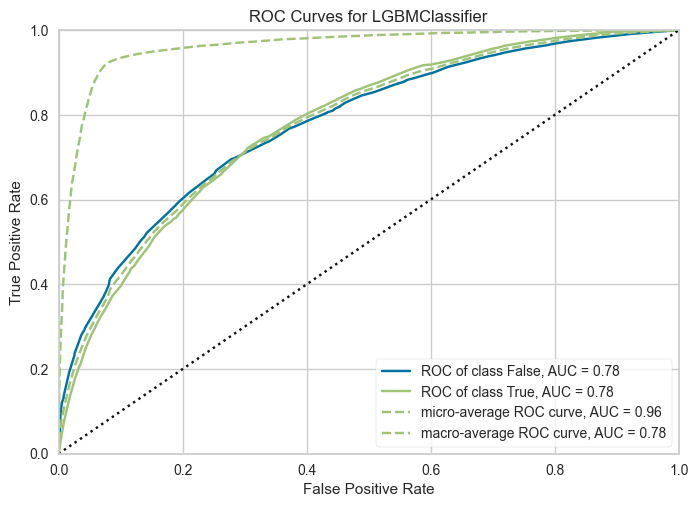

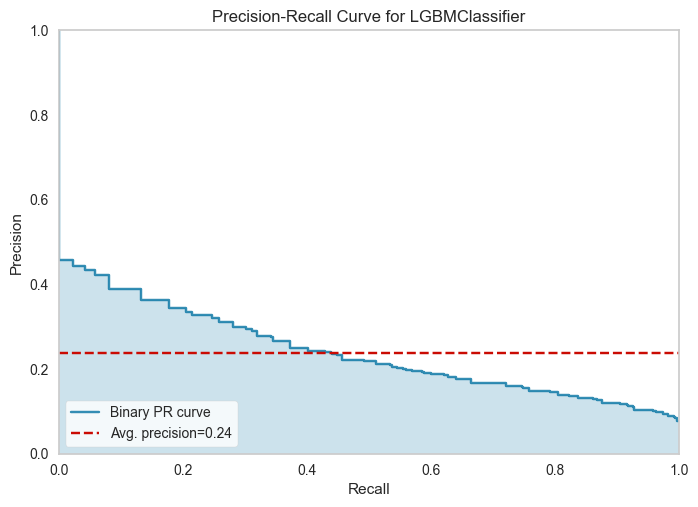

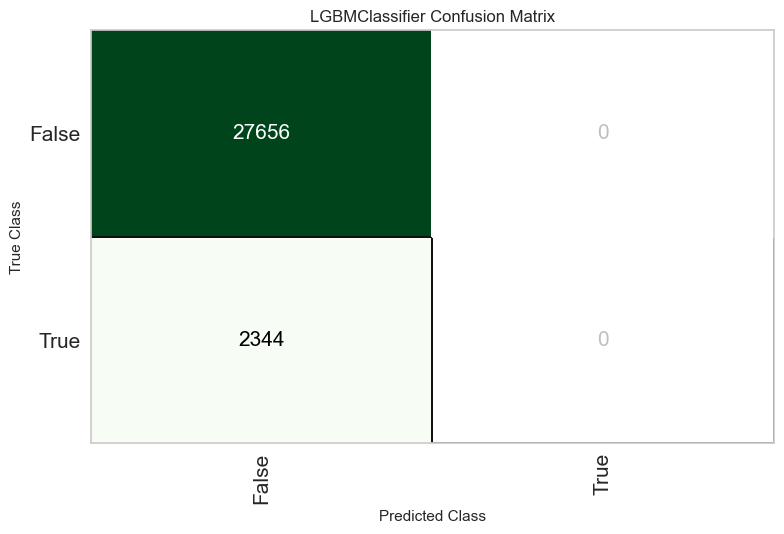

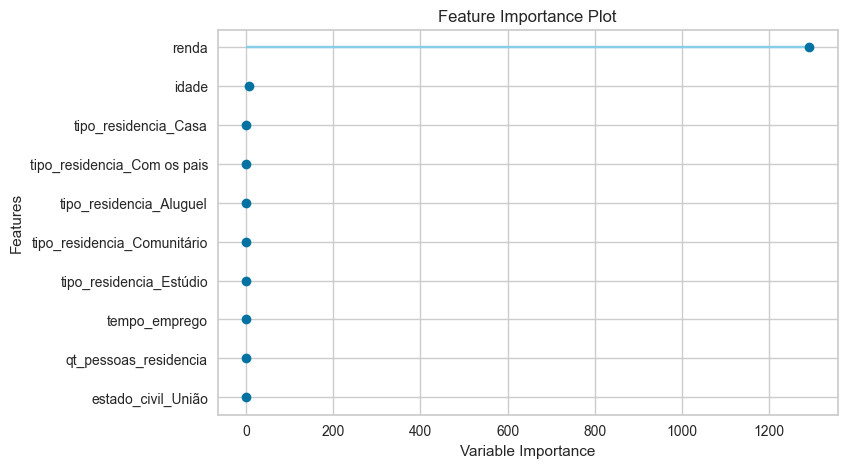

In [10]:
# gráficos
plot_model(lgbm_tuned, plot="auc")
plot_model(lgbm_tuned, plot="pr")
plot_model(lgbm_tuned, plot="confusion_matrix")
plot_model(lgbm_tuned, plot="feature")

# finalizar modelo
final_lgbm = finalize_model(lgbm_tuned)

# salvar modelo com save_model(final_lgbm, "artifacts/pycaret_lightgbm_credit")


#### Finalizar o modelo (pipeline completo)

In [11]:
# - Finalizar modelo (pipeline + LightGBM) usando a base reduzida

final_lgbm = finalize_model(lgbm_tuned)
print("Modelo finalizado: pronto para uso em produção (final_lgbm).")
final_lgbm


Modelo finalizado: pronto para uso em produção (final_lgbm).


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='median',
                                                              verbose='deprecated'))),
                ('categorical_...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=1.0,
                                importance_type='split', learning_rate=0.005,
                                max_depth=-1, min_child_samples=31,
                                min_child_weight=0.001, min_split_gain=0.4,
                                n_estimators=260, n_jobs=-1, num_leaves=6,
                                objective=None, random_state=42, reg_alpha=3,
                                reg_lambda=1e-07, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

#### 17 - Salvar o arquivo do modelo treinado

In [12]:
# - Salvar o modelo LightGBM treinado pelo PyCaret

import pathlib
pathlib.Path("artifacts").mkdir(exist_ok=True)

save_model(final_lgbm, "artifacts/pycaret_lightgbm_credit")

print("Modelo PyCaret salvo em: artifacts/pycaret_lightgbm_credit.pkl")


Transformation Pipeline and Model Successfully Saved
Modelo PyCaret salvo em: artifacts/pycaret_lightgbm_credit.pkl


#### Conclusão Final — Projeto de Credit Scoring (Partes A + B)

O projeto teve como objetivo desenvolver um modelo de credit scoring para uma base de clientes de cartão de crédito, composta por 15 safras mensais e 12 meses de performance. O trabalho foi dividido em duas etapas principais: a modelagem manual (Pipeline + Regressão Logística) e a modelagem automatizada com PyCaret (LightGBM).

#### Parte A — Pipeline Manual com Regressão Logística

Nesta etapa foi construído um pipeline completo de pré-processamento utilizando scikit-learn. As etapas incluíram:

Imputação de valores nulos (mediana para numéricos e moda para categóricos);

Tratamento de outliers via IQR capping;

Redução de dimensionalidade com PCA (5 componentes principais);

Criação de dummies com OneHotEncoder;

Construção de um pipeline integrado (pré-processamento + regressão logística).

O modelo de Regressão Logística apresentou desempenho satisfatório e manteve boa interpretabilidade, característica essencial em aplicações de risco de crédito. Esta etapa representou a construção manual e detalhada de um fluxo reprodutível, permitindo entender passo a passo o impacto das transformações no modelo.

#### Parte B — Automação da Modelagem com PyCaret (LightGBM)

A segunda etapa utilizou o PyCaret para acelerar o processo de pré-processamento, comparação de algoritmos e seleção do modelo final.
O algoritmo LightGBM foi escolhido após o tuning, apresentando aproximadamente:

AUC ≈ 0.78

Acurácia ≈ 92%

Kappa ≈ 0.04

Esses resultados mostram boa capacidade discriminatória mesmo em uma base desbalanceada — cenário típico em problemas de crédito.

Os gráficos gerados (Curva ROC, Matriz de Confusão, Precision-Recall e Importância das Variáveis) demonstraram estabilidade e coerência do modelo. O pipeline final, exportado diretamente pelo PyCaret, garante total reprodutibilidade e rastreabilidade das etapas de transformação.

#### Síntese Final

O projeto consolida o aprendizado de um ciclo completo de modelagem de credit scoring, abordando:

construção manual e automatizada de pipelines;

uso de métricas adequadas para problemas desbalanceados (AUC, KS, Gini);

validação temporal (safras OOT);

separação adequada entre bases de desenvolvimento e teste;

integração das etapas em pipelines reprodutíveis e prontos para implantação.

A comparação entre a Regressão Logística e o LightGBM evidencia a evolução natural de um time de Data Science:
da explicabilidade estatística ao ganho de desempenho técnico e operacional.

Assim, o projeto representa uma entrega completa, alinhada às práticas aplicadas em instituições financeiras de mercado.

# 18 - Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.